In [149]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Import dataset

### I use data from 2012 to 2014 as train and 2015 data as test because my computer can't handle all the data.

In [134]:
columns = ["Transaction unique identifier","Price", "Date of Transfer","Postcode", "Property Code",
              "Old/New","Duration","PAON","SAON","Street","Locality",
              "Town/City","District","County","PPD Category Type","Record Status"]

df_2012_1 = pd.read_csv("./data/pp-2012-part1.csv", sep=",")
df_2012_1.columns = columns
df_2012_2 = pd.read_csv("./data/pp-2012-part2.csv", sep=",")
df_2012_2.columns = columns
df_2013_1 = pd.read_csv("./data/pp-2013-part1.csv", sep=",")
df_2013_1.columns = columns
df_2013_2 = pd.read_csv("./data/pp-2013-part2.csv", sep=",")
df_2013_2.columns = columns
df_2014_1 = pd.read_csv("./data/pp-2014-part1.csv", sep=",")
df_2014_1.columns = columns
df_2014_2 = pd.read_csv("./data/pp-2014-part2.csv", sep=",")
df_2014_2.columns = columns
df_train = [df_2012_1, df_2012_2, df_2013_1, df_2013_2, df_2014_1, df_2014_2]
df_train = pd.concat(df_train)

df_2015_1 = pd.read_csv("./data/pp-2015-part1.csv", sep=",")
df_2015_1.columns = columns
df_2015_2 = pd.read_csv("./data/pp-2015-part2.csv", sep=",")
df_2015_2.columns = columns
df_test = [df_2015_1, df_2015_2]
df_test = pd.concat(df_test)

df_train.head()

,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Code,Old/New,Duration,PAON,SAON,Street,Locality,Town/City,District,County,PPD Category Type,Record Status
0,{F6CA8404-B100-471F-9350-5D64A729A0D1},125000,2012-10-05 00:00,SS1 2RT,F,N,L,8,NaN,HONITON ROAD,NaN,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,A
1,{9DFDD84B-7D1C-4653-A630-6B974380B686},174000,2012-02-09 00:00,TS12 2WP,D,N,F,9,NaN,LONGTHWAITE CLOSE,SKELTON IN CLEVELAND,SALTBURN-BY-THE-SEA,REDCAR AND CLEVELAND,REDCAR AND CLEVELAND,A,A
2,{72C52A7A-FD12-4341-96C9-6B9766FBEDB8},161000,2012-01-27 00:00,BD10 8RW,D,N,F,12,NaN,CROFTLANDS,NaN,BRADFORD,BRADFORD,WEST YORKSHIRE,A,A
3,{3B878B99-848F-4465-A8BD-6470495AA086},210000,2012-06-12 00:00,NN3 9TU,D,N,F,52,NaN,RUSSET DRIVE,LITTLE BILLING,NORTHAMPTON,NORTHAMPTON,NORTHAMPTONSHIRE,A,A
4,{D41CCC26-D63F-47E2-A1D0-64705F83A61F},437000,2012-12-21 00:00,RH10 8DZ,D,Y,F,"THE HOLLIES, 2A",NaN,HOLLYBUSH ROAD,NaN,CRAWLEY,CRAWLEY,WEST SUSSEX,A,A


# Handling null values

In [135]:
print("----------------Checking null values for X_train---------------\n")
for column in df_train:
    print(column, "has", df_train[column].isnull().sum(), "null values")

print("\n----------------Checking null values for X_test---------------\n")
for column in df_train:
    print(column, "has", df_train[column].isnull().sum(), "null values")

----------------Checking null values for X_train---------------

Transaction unique identifier has 0 null values
Price has 0 null values
Date of Transfer has 0 null values
Postcode has 1780 null values
Property Code has 0 null values
Old/New has 0 null values
Duration has 0 null values
PAON has 8 null values
SAON has 2145673 null values
Street has 36330 null values
Locality has 1582441 null values
Town/City has 0 null values
District has 0 null values
County has 0 null values
PPD Category Type has 0 null values
Record Status has 0 null values

----------------Checking null values for X_test---------------

Transaction unique identifier has 0 null values
Price has 0 null values
Date of Transfer has 0 null values
Postcode has 1780 null values
Property Code has 0 null values
Old/New has 0 null values
Duration has 0 null values
PAON has 8 null values
SAON has 2145673 null values
Street has 36330 null values
Locality has 1582441 null values
Town/City has 0 null values
District has 0 null va

### Deleting features that has to much null values

In [136]:
# SAON, Street, locality have to much null values to be used properly, so I won't use these features.
df_train = df_train.drop(['SAON', 'Street', 'Locality'], axis=1)
df_test = df_test.drop(['SAON', 'Street', 'Locality'], axis=1)

# Handling date feature

### Price might vary over time, i will check median prices year by year

In [137]:
# Extract year from date of transfer
def DateToYear(date):
    return date[0 : 4]
    
#change date feature to year 
df_train["Date of Transfer"] = df_train["Date of Transfer"].map(lambda date: DateToYear(date))
df_test["Date of Transfer"] = df_test["Date of Transfer"].map(lambda date: DateToYear(date))

#checking median prices by year
unique_year_values = df_train["Date of Transfer"].unique()
for year in unique_year_values:
    print("median price for house sold in", year, ':', df_train[df_train["Date of Transfer"] == year]['Price'].median())

median price for house sold in 2012 : 180000.0
median price for house sold in 2013 : 184995.0
median price for house sold in 2014 : 190000.0


### The price seems to go up over time, so we will use the years in which the house was sold has a feature.

In [138]:
df_train["Date of Transfer"] = df_train["Date of Transfer"].map(lambda year: int(year))
df_test["Date of Transfer"] = df_test["Date of Transfer"].map(lambda year: int(year))

# Localisation features

### As instructed, i will only use whether or not the house is in London for the feature "Town/City".

In [139]:
df_train["isInLondon"] = df_train["Town/City"].map(lambda town: 1 if town == "LONDON" else 0)
df_test["isInLondon"] = df_test["Town/City"].map(lambda town: 1 if town == "LONDON" else 0)

### Using District and County should have a positive impact on the model but I will only use isInLondon as a localisation feature here so i don't add to many features. Using get dummies on these features could have been a solution to use the values.

In [140]:
df_train = df_train.drop(['District', 'PAON', 'County', 'Town/City'], axis=1)
df_test = df_test.drop(['District', 'PAON', 'County', 'Town/City'], axis=1)

# PPD Category Type and Record Status

### I'm checking the ditribution of values for PPD Category Type and Record Status to see if they are relevant

In [141]:
print(df_train['PPD Category Type'].value_counts())
print(df_train['Record Status'].value_counts())

A    2378396
B      85341
Name: PPD Category Type, dtype: int64
A    2463737
Name: Record Status, dtype: int64


### 'Record Status' contains only 1 value here so it doesn't make sense to keep it.

In [142]:
df_train = df_train.drop(['Record Status'], axis=1)
df_test = df_test.drop(['Record Status'], axis=1)

# Changing last useful features to numerical so they can be used in a model

In [144]:
def propertyCodeToInt(code):
    if code == 'D':
        return 1
    elif code == 'S':
        return 2
    elif code == 'T':
        return 3
    elif code == 'F':
        return 4
    else:
        return 0
    
def PPDCategoryTypeToInt(category):
    if category == 'A':
        return 0
    elif category == 'B':
        return 1

df_train["Old/New"] = df_train["Old/New"].map(lambda isOld: 1 if isOld == "Y" else 0)
df_test["Old/New"] = df_test["Old/New"].map(lambda town: 1 if town == "Y" else 0)

df_train["Duration"] = df_train["Duration"].map(lambda duration: 1 if duration == "F" else 0)
df_test["Duration"] = df_test["Duration"].map(lambda town: 1 if town == "F" else 0)

df_train["Property Code"] = df_train["Property Code"].map(lambda code: propertyCodeToInt(code))
df_test["Property Code"] = df_test["Property Code"].map(lambda code: propertyCodeToInt(code))

df_train["PPD Category Type"] = df_train["PPD Category Type"].map(lambda code: propertyCodeToInt(code))
df_test["PPD Category Type"] = df_test["PPD Category Type"].map(lambda code: propertyCodeToInt(code))

# Dropping last useless features

### Some features doesn't make sense to predict the price of the house, such as 'Transaction unique identifier' or 'Postcode'

In [145]:
df_train = df_train.drop(['Transaction unique identifier', 'Postcode'], axis=1)
df_test = df_test.drop(['Transaction unique identifier', 'Postcode'], axis=1)

# Using correlation matrix to have an insight on ou data

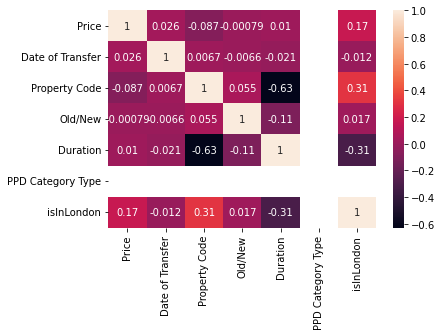

In [146]:
corrMatrix = df_train.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

We're looking at the first row or first column.

The feature instructed "isInLondon" seems to have a good impact on the price and is relevant. The others features however doesn't show a good correlation with the price we are trying to be predict.

Based on this correlation matrix it appears we either miss some informations or we need more feature engineering predict the price precisly. 

# Splitting X and Y

In [147]:
Y_train = df_train['Price']
X_train = df_train.drop(['Price'], axis=1)

Y_test = df_test['Price']
X_test = df_test.drop(['Price'], axis=1)

print(X_test.columns)
print(X_train.columns)

Index(['Date of Transfer', 'Property Code', 'Old/New', 'Duration',
       'PPD Category Type', 'isInLondon'],
      dtype='object')
Index(['Date of Transfer', 'Property Code', 'Old/New', 'Duration',
       'PPD Category Type', 'isInLondon'],
      dtype='object')


# Testing models

In [151]:
regressor = LinearRegression().fit(X_train, Y_train)

Y_pred = regressor.predict(X_test)
print("r2_score for linear regression :", r2_score(Y_test, Y_pred))

regressor = tree.DecisionTreeRegressor().fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
print("r2_score for decision tree :", r2_score(Y_test, Y_pred))

regressor = RandomForestRegressor(max_depth=10, random_state=0).fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
print("r2_score for decision tree :", r2_score(Y_test, Y_pred))

r2_score for linear regression : 0.041546574246906665
r2_score for decision tree : 0.10222012434766325
r2_score for decision tree : 0.10236539269127043


The best model here is the decision tree, we could test more parameters to be sure the model chosen is the right one and increase
the quality of our prediction.
The score obtained makes sense according to correlation we saw in the correlation matrix.